In [1]:
import sys
sys.path.append('../')

import lib.graphLib.graph as g
from lib.graphLib.vertex import Vertex
from lib.graphLib.edge import Edge

from lib.constants import *
import lib.utils as utils

import igraph
import copy
import drawSvg as draw
import math

C:\Users\Christoph Weberbauer\AppData\Local\Programs\Python\Python39\lib\site-packages\drawSvg\raster.py:18: RuntimeWarning: Failed to import CairoSVG. drawSvg will be unable to output PNG or other raster image formats. See https://github.com/cduck/drawSvg#prerequisites for more details.
Original OSError: no library called "cairo-2" was found
no library called "cairo" was found
cannot load library 'C:\GTK\bin\libcairo-2.dll': error 0xc1
cannot load library 'libcairo.so.2': error 0x7e
cannot load library 'libcairo.2.dylib': error 0x7e
cannot load library 'libcairo-2.dll': error 0x7f
  warnings.warn(msg, RuntimeWarning)


##### Generate Test data

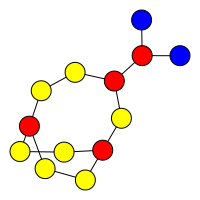

In [2]:
graph = g.Graph()

v0 = Vertex("red",attr={"coordinates":[165,50]})
v1 = Vertex("yellow",attr={"coordinates":[169,57]})
v2 = Vertex("yellow",attr={"coordinates":[196,52]})
v3 = Vertex("red",attr={"coordinates":[197,50]})
v4 = Vertex("yellow",attr={"coordinates":[193,43]})
v5 = Vertex("yellow",attr={"coordinates":[166,47]})

v6 = Vertex("yellow",attr={"coordinates":[242,47]})
v7 = Vertex("red",attr={"coordinates":[244,211]})
v8 = Vertex("yellow",attr={"coordinates":[90,220]})
v9 = Vertex("yellow",attr={"coordinates":[92,56]})

v10 = Vertex("red",attr={"coordinates":[245,240]})
v11 = Vertex("blue",attr={"coordinates":[259,241]})
v12 = Vertex("blue",attr={"coordinates":[229,241]})

graph.addVertices([v0,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12])
graph.addEdge(Edge(),v0.id,v1.id)
graph.addEdge(Edge(),v1.id,v2.id)
graph.addEdge(Edge(),v2.id,v3.id)
graph.addEdge(Edge(),v3.id,v4.id)
graph.addEdge(Edge(),v4.id,v5.id)
graph.addEdge(Edge(),v5.id,v0.id)

graph.addEdge(Edge(),v3.id,v6.id)
graph.addEdge(Edge(),v6.id,v7.id)
graph.addEdge(Edge(),v7.id,v8.id)
graph.addEdge(Edge(),v8.id,v9.id)
graph.addEdge(Edge(),v9.id,v0.id)

graph.addEdge(Edge(),v7.id,v10.id)
graph.addEdge(Edge(),v10.id,v11.id)
graph.addEdge(Edge(),v10.id,v12.id)

buildingParts = [
    ("resistor","horizontal",[v0,v1,v2,v3,v4,v5]),
    ("ground","vertical",[v10,v11,v12,])
]

igraphUnion = utils.convertToIgraph(graph)
layout = igraphUnion.layout("kk") #"large_graph"
igraph.plot(igraphUnion, layout=layout,bbox = (200,200))

### Convert Coordinates to Relative Values

In [3]:
#get lenght of the longest resistor
len = -1
for buildingPart in buildingParts:
    vertices = buildingPart[2]
    rotation = buildingPart[1]
    type_ = buildingPart[0]

    if not type_ == CLASS_NAMES["res"]:
        continue
    
    xVals = list(map(lambda v: v.attr["coordinates"][0],vertices))
    yVals = list(map(lambda v: v.attr["coordinates"][1],vertices))

    xDist = max(xVals) - min(xVals)
    yDist = max(yVals) - min(yVals)

    if xDist > yDist:
        if xDist > len:
            len = xDist
    else:
        if yDist > len:
            len = yDist


#convert all coordinates to values, relative to the resistor
for vertex in graph.ve.values():
    x = vertex.attr["coordinates"][0]
    y = vertex.attr["coordinates"][1]
    vertex.attr["coordinates"] = [x/len,y/len]

### Snap Coordinates to Grid 

In [4]:

for vertex in graph.ve.values():
    gridSize = 1
    x = math.floor(vertex.attr["coordinates"][0]/gridSize)*gridSize
    y = math.floor(vertex.attr["coordinates"][1]/gridSize)*gridSize
    vertex.attr["coordinates"] = [x,y]

### Modify Graph

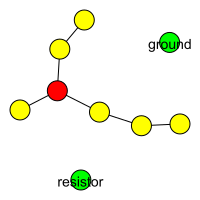

In [5]:
#Get all the vertices connected to a building part
for buildingPart in buildingParts:
    vertices = buildingPart[2]
    rotation = buildingPart[1]
    type_ = buildingPart[0]

    #get all intersections
    intersectionVertices = list (filter(lambda v: v.color == INTERSECTION_COLOR,vertices) )

    #match LTSpice Model connections with graph Model connections
    connectionMap = {}
    

    #CHAAAANGE
    #CHAAAANGE
    #CHAAAANGE
    #CHAAAANGE
    #TODO!! CHANGE
    index = 0
    for intersectionPoint in intersectionVertices:
        connectionMap[index] = intersectionPoint.attr["coordinates"]
        index+=1
    #TODO!! CHANGE
    #CHAAAANGE
    #CHAAAANGE
    #CHAAAANGE
    #CHAAAANGE

    #get center of the component
    xVals = list(map(lambda v: v.attr["coordinates"][0],vertices))
    yVals = list(map(lambda v: v.attr["coordinates"][1],vertices))

    xDist = max(xVals) - min(xVals)
    yDist = max(yVals) - min(yVals)
    center = [min(xVals)+xDist/2,min(yVals)+yDist/2]

    #delete all vertices of the component accept the intersection points, change type to edge for them!
    for vertex in vertices:
        if vertex.color == INTERSECTION_COLOR:
            vertex.color = CORNER_COLOR
            continue
        graph.deleteVertex(vertex.id)
    
    #add UNCONECTED component Vertex
    component = Vertex(
            color=COMPONENT_COLOR,
            label=type_,
            attr={"connectionMap":connectionMap,"type":type_,"coordinates":center}
        )
    graph.addVertex(component)

igraphUnion = utils.convertToIgraph(graph)
layout = igraphUnion.layout("fr") #"large_graph"
igraph.plot(igraphUnion, layout=layout,bbox = (200,200))

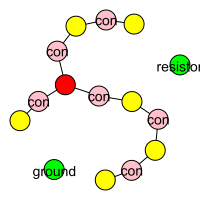

In [6]:
#for every Edge
#freeze graph
frozenGraph = copy.deepcopy(graph)
for edge in frozenGraph.ed.values():

    #get Vertices connected to Edge
    vertices = graph.getVerticesForEdge(edge.id)
    
    #insert Connection Vertex
    connection = Vertex(
        color=CONNECTION_COLOR,
        label="con",
        attr={
            "from"  :vertices[0].attr["coordinates"],
            "to"    :vertices[1].attr["coordinates"],
        }
    )
    graph.insertVertexByEdge(edge.id,connection)


igraphUnion = utils.convertToIgraph(graph)
layout = igraphUnion.layout("fr") #"large_graph"
igraph.plot(igraphUnion, layout=layout,bbox = (200,200))


### Draw the Cuircit

In [7]:

width,height = 500,500
d = draw.Drawing(width, height,displayInline=False)

relativeFactor = 40


def drawResistor(resistorVertex):

    resistorWidth = relativeFactor
    resistorHeight = 20

    coordinates = [resistorVertex.attr["coordinates"][0]*relativeFactor,resistorVertex.attr["coordinates"][1]*relativeFactor]
    
    d.append(draw.Rectangle(coordinates[0]-resistorWidth/2,height-coordinates[1]-resistorHeight/2,resistorWidth,resistorHeight, stroke='#1248ff'))

    #connect Resistor to connectionpoints
    connectionPoint1 = [coordinates[0]-resistorWidth/2,coordinates[1]]
    to1 = resistorVertex.attr["connectionMap"][0]

    connectionPoint2 = [coordinates[0]+resistorWidth/2,coordinates[1]]
    to2 = resistorVertex.attr["connectionMap"][1]

    d.append(draw.Lines(connectionPoint1[0],height-connectionPoint1[1], to1[0]*relativeFactor, height-to1[1]*relativeFactor ,stroke="#ff4477"))
    d.append(draw.Lines(connectionPoint2[0],height-connectionPoint2[1], to2[0]*relativeFactor, height-to2[1]*relativeFactor ,stroke="#ff4477"))


def drawWire(connectionVertex):
    from_ = connectionVertex.attr["from"]
    to_ = connectionVertex.attr["to"]
    d.append(draw.Lines(from_[0]*relativeFactor, height-from_[1]*relativeFactor, to_[0]*relativeFactor,width-to_[1]*relativeFactor,stroke="#ff4477"))


def drawGround(groundVertex):
    groundSize = 30

    coordinates = [groundVertex.attr["connectionMap"][0][0]*relativeFactor,groundVertex.attr["connectionMap"][0][1]*relativeFactor]

    d.append(draw.Lines(coordinates[0],height-coordinates[1], coordinates[0]-groundSize, height-coordinates[1] ,stroke="#ff4477"))
    d.append(draw.Lines(coordinates[0],height-coordinates[1], coordinates[0]+groundSize, height-coordinates[1] ,stroke="#ff4477"))

def drawIntersection(intersectionVertex):
    coordinates = [intersectionVertex.attr["coordinates"][0]*relativeFactor,intersectionVertex.attr["coordinates"][1]*relativeFactor]

    d.append(draw.Circle(coordinates[0],height-coordinates[1],5))

for vertex in graph.ve.values():
    if not vertex.color == COMPONENT_COLOR:
        continue
    if vertex.attr["type"] == CLASS_NAMES["res"]:
        drawResistor(vertex)
    elif vertex.attr["type"] == CLASS_NAMES["gnd"]:
        drawGround(vertex)
for vertex in graph.ve.values():
    if not vertex.color == CONNECTION_COLOR:
        continue
    drawWire(vertex)
for vertex in graph.ve.values():
    if not vertex.color == INTERSECTION_COLOR:
        continue
    drawIntersection(vertex)
d